In [ ]:
#https://github.com/GenTaylor/Traffic-Accident-Analysis/blob/master/Machine_Learning_UK_Road_Safety_Traffic_Accidents_and_Vehicles.ipynb
#https://www.askpython.com/python/examples/precision-and-recall-in-python

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

In [54]:
import pandas as pd
import numpy as np
import warnings
import plotly.graph_objs as go
import colorlover as cl
from IPython.display import HTML
from IPython.display import display
import chart_studio.plotly as py
from plotly import tools
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from itertools import cycle
from sklearn.metrics import classification_report

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
#from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, recall_score, auc, roc_auc_score, confusion_matrix, log_loss, precision_score,recall_score

import cufflinks as cf
cf.go_offline() #will make cufflinks offline
cf.set_config_file(offline=False, world_readable=True)
from plotly.offline import iplot

bupu = cl.scales['9']['seq']['BuPu']
HTML( cl.to_html(bupu))

warnings.filterwarnings("ignore") 

### 1. Loading the data

In [3]:
UK_acc_data0521 = pd.read_csv("data/numeric_acc_0521.csv")

In [4]:
UK_acc_data0521.head()

,accident_index,first_road_class,first_road_number,accident_severity,carriageway_hazards,day_of_week,junction_control,junction_detail,latitude,light_conditions,...,speed_limit,time,urban_or_rural_area,weather_conditions,accident_year,pedestrian_crossing_human_control,pedestrian_crossing_physical_facilities,did_police_officer_attend_scene_of_accident,month,date
0,200501BS00001,3,3218.0,2,0,3,-1,0,51.489096,1,...,30.0,17:42,1,2,2005,0.0,1.0,1.0,1,2005-01-04
1,200501BS00002,4,450.0,3,0,4,2,6,51.520075,4,...,30.0,17:36,1,1,2005,0.0,5.0,1.0,1,2005-01-05
2,200501BS00003,5,0.0,3,0,5,-1,0,51.525301,4,...,30.0,00:15,1,1,2005,0.0,0.0,1.0,1,2005-01-06
3,200501BS00004,3,3220.0,3,0,6,-1,0,51.482442,1,...,30.0,10:35,1,1,2005,0.0,0.0,1.0,1,2005-01-07
4,200501BS00005,9,0.0,3,0,2,-1,0,51.495752,7,...,30.0,21:13,1,1,2005,0.0,0.0,1.0,1,2005-01-10


In [5]:
UK_acc_data0521.shape

(2479713, 31)

In [6]:
UK_acc_data0521['accident_severity'].value_counts()

3    2075224
2     371926
1      32563
Name: accident_severity, dtype: int64

In [ ]:
#severity = {1:'Fatal', 2:'Serious',3:'Slight'}
#UK_acc_data0521 = UK_acc_data0521.replace({"accident_severity": severity})
#UK_acc_data0521['accident_severity'].value_counts()

In [7]:
UK_acc_data0521.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2479713 entries, 0 to 2479712
Data columns (total 31 columns):
 #   Column                                       Dtype  
---  ------                                       -----  
 0   accident_index                               object 
 1   first_road_class                             int64  
 2   first_road_number                            float64
 3   accident_severity                            int64  
 4   carriageway_hazards                          int64  
 5   day_of_week                                  int64  
 6   junction_control                             int64  
 7   junction_detail                              int64  
 8   latitude                                     float64
 9   light_conditions                             int64  
 10  local_authority_district                     object 
 11  local_authority_highway                      object 
 12  location_easting_osgr                        float64
 13  location_nor

## Preprocessing 

In [8]:
X = UK_acc_data0521.drop(['accident_index','latitude','location_easting_osgr','longitude','location_northing_osgr',
                     'date','accident_severity'], axis = 1)

In [9]:
X.shape

(2479713, 24)

In [10]:
#separate dtypes
cat_data = X.select_dtypes(exclude=['int','float','int64','float64'])
num_data = X.select_dtypes(include=['int','float','int64','float64'])
print('catagory data columns',cat_data.columns)
print("\n Numeric data columns",num_data.columns)

print(cat_data.shape)
print(num_data.shape)

catagory data columns Index(['local_authority_district', 'local_authority_highway', 'time'], dtype='object')

 Numeric data columns Index(['first_road_class', 'first_road_number', 'carriageway_hazards',
       'day_of_week', 'junction_control', 'junction_detail',
       'light_conditions', 'number_of_casualties', 'number_of_vehicles',
       'police_force', 'road_surface_conditions', 'road_type',
       'special_conditions_at_site', 'speed_limit', 'urban_or_rural_area',
       'weather_conditions', 'accident_year',
       'pedestrian_crossing_human_control',
       'pedestrian_crossing_physical_facilities',
       'did_police_officer_attend_scene_of_accident', 'month'],
      dtype='object')
(2479713, 3)
(2479713, 21)


In [11]:
#label encode objects
obj_lable_encoded = cat_data.apply(LabelEncoder().fit_transform)

In [12]:
# concatenating feaures
X_final = pd.concat([obj_lable_encoded,num_data], axis=1, sort=False)
Y_final = UK_acc_data0521['accident_severity']

In [13]:
X_final.shape , Y_final.shape

((2479713, 24), (2479713,))

### Extra Tree Classifier 

In [14]:
#https://www.geeksforgeeks.org/ml-extra-tree-classifier-for-feature-selection/

In [15]:
extra_tree_forest = ExtraTreesClassifier(n_estimators = 5, criterion ='entropy', max_features = 2)

In [16]:
# Training the model
extra_tree_forest.fit(X_final, Y_final)

ExtraTreesClassifier(criterion='entropy', max_features=2, n_estimators=5)

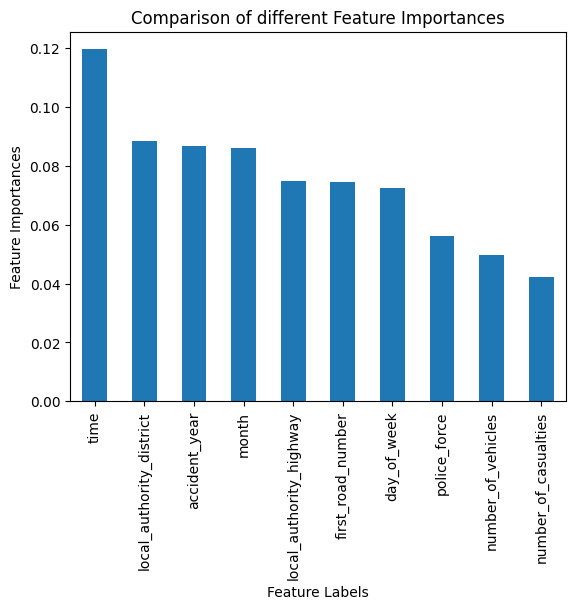

In [17]:
feat_importances = pd.Series(extra_tree_forest.feature_importances_, index=X_final.columns)
plt.xlabel('Feature Labels')
plt.ylabel('Feature Importances')
plt.title('Comparison of different Feature Importances')
feat_importances.nlargest(10).plot.bar()
plt.show()

In [18]:
best_selected_features = feat_importances.nlargest(10).keys().to_list()

In [19]:
best_selected_features         

['time',
 'local_authority_district',
 'accident_year',
 'month',
 'local_authority_highway',
 'first_road_number',
 'day_of_week',
 'police_force',
 'number_of_vehicles',
 'number_of_casualties']

### Using best selected features 

In [20]:
X_col = X_final.columns

In [21]:
drop_feature_list = []

for col_val in X_col:
    if col_val not in best_selected_features:
        drop_feature_list.append(col_val)

In [22]:
drop_feature_list

['first_road_class',
 'carriageway_hazards',
 'junction_control',
 'junction_detail',
 'light_conditions',
 'road_surface_conditions',
 'road_type',
 'special_conditions_at_site',
 'speed_limit',
 'urban_or_rural_area',
 'weather_conditions',
 'pedestrian_crossing_human_control',
 'pedestrian_crossing_physical_facilities',
 'did_police_officer_attend_scene_of_accident']

In [23]:
X_final = X_final.drop(drop_feature_list, axis=1)
X_final.shape

(2479713, 10)

In [24]:
X_final.describe()

,local_authority_district,local_authority_highway,time,first_road_number,day_of_week,number_of_casualties,number_of_vehicles,police_force,accident_year,month
count,2.479713e+06,2.479713e+06,2.479713e+06,2.479713e+06,2.479713e+06,2.479713e+06,2.479713e+06,2.479713e+06,2.479713e+06,2.479713e+06
mean,2.202862e+02,1.073764e+02,8.425357e+02,9.552539e+02,4.114961e+00,1.335975e+00,1.835012e+00,3.007723e+01,2.012071e+03,6.634070e+00
std,1.195863e+02,4.903277e+01,3.083091e+02,1.772916e+03,1.924765e+00,8.027043e-01,7.123236e-01,2.534711e+01,4.822843e+00,3.429003e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.005000e+03,1.000000e+00
25%,1.100000e+02,7.200000e+01,6.150000e+02,0.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,6.000000e+00,2.008000e+03,4.000000e+00
50%,2.480000e+02,1.200000e+02,8.850000e+02,9.300000e+01,4.000000e+00,1.000000e+00,2.000000e+00,3.000000e+01,2.012000e+03,7.000000e+00
75%,3.160000e+02,1.410000e+02,1.070000e+03,6.730000e+02,6.000000e+00,1.000000e+00,2.000000e+00,4.500000e+01,2.016000e+03,1.000000e+01
max,4.280000e+02,2.090000e+02,1.439000e+03,9.999000e+03,7.000000e+00,9.300000e+01,6.700000e+01,9.900000e+01,2.021000e+03,1.200000e+01


## splitting the data

In [25]:
# Split the 'features' and 'income' data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_final, Y_final, test_size = 0.2, random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 1983770 samples.
Testing set has 495943 samples.


## Model Applying

In [26]:
target_severity = ["Fatal","Serious","Slight"]

In [27]:
#final result df
col_val = ["Training Acc","Test acc", "Log Loss", "precision", "Recall", "F1 Score","False Positive Rate", "Error Rate"]
Performance_df = pd.DataFrame(columns = col_val)

In [28]:
def plot_conf_matrix(cm):
    # Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
    cm_df = pd.DataFrame(cm,index = ['Fatal', 'Serious', 'Slight'], 
                         columns = ['Fatal', 'Serious', 'Slight'])
    #Plotting the confusion matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(cm_df, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')
    plt.show()

In [29]:
##https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
def plot_auc_roc_curve(classifier, X_train, y_train, X_test, y_test,target_severity):
    label_binarizer = LabelBinarizer().fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)
    y_onehot_test.shape  # (n_samples, n_classes)
    n_classes = len(np.unique(Y_final))
    y_score = classifier.predict_proba(X_test)
    
    fig, ax = plt.subplots(figsize=(6, 6))

    colors = cycle(["aqua", "orange", "green"])
    for class_id, color in zip(range(n_classes), colors):
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_score[:, class_id],
            name=f"ROC curve for {target_severity [class_id]}",
            color=color,
            ax=ax,
        )

    plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic for multiclass")
    plt.legend()
    plt.show()

In [30]:
def model_applying(classifier, X_train, y_train, X_test, y_test,target_severity,Performance_df):
    classifier.fit(X_train, y_train)
    
    y_pred_train = classifier.predict(X_train)
    y_pred_test = classifier.predict(X_test)
    
    acc1 = metrics.accuracy_score(y_train, y_pred_train)
    acc2 = metrics.accuracy_score(y_test, y_pred_test)
    
    test_probability = classifier.predict_proba(X_test)
    logloss = log_loss(y_test, test_probability)
    
    report_df = pd.DataFrame(classification_report(y_test, y_pred_test, target_names=target_severity,output_dict=True)).transpose()
    
    precision = report_df["precision"]["macro avg"]
    recall = report_df["recall"]["macro avg"]
    f1_score = report_df["f1-score"]["macro avg"]
    
    cm = confusion_matrix(y_test, y_pred_test)
    #FPR and Error Rate setup
    TN = cm[0][0]
    FN = cm[1][0]
    TP = cm[1][1]
    FP = cm[0][1]
    FPR = FP /(TN + FP)
    error_rate = 1-acc2
    
    
    print("Training Accuracy: {:.4%}".format(acc1))
    print(classification_report(y_train, y_pred_train, target_names=target_severity ))
    print("Test Accuracy: {:.4%}".format(acc2))
    print(classification_report(y_test, y_pred_test, target_names=target_severity ))
    plot_conf_matrix(cm)
    plot_auc_roc_curve(classifier, X_train, y_train, X_test, y_test,target_severity)
          
          
    result_values = pd.DataFrame([[round(acc1*100,3),round(acc2*100,3), round(logloss*100,3),round(precision*100,3), 
                               round(recall*100,3), round(f1_score*100,3) , round(FPR*100,3),
                               round(error_rate*100,3),]], columns= col_val)
    Performance_df = Performance_df.append(result_values)
    return Performance_df

## 1. applying Random Forest

In [ ]:
clf1 = RandomForestClassifier(criterion='entropy', n_estimators=100, random_state=42, max_depth=10)

In [ ]:
print("-"*20+" Random Forest Classifier "+"-"*20)
Performance_df = model_applying(clf1, X_train, y_train, X_test, y_test,target_severity,Performance_df)

In [ ]:
feat_importances1 = pd.Series(clf1.feature_importances_, index=X_final.columns)
plt.xlabel('Feature Labels')
plt.ylabel('Feature Importances')
plt.title('Comparison of different Feature Importances with Random Forest')
feat_importances1.nlargest().plot.bar()
plt.show()

In [ ]:
Performance_df

In [ ]:
Performance_df.to_csv("Performance_df.csv", index= False)

## 2. Applying XGBoost 

In [ ]:
clf2 = XGBClassifier(learning_rate=0.05, random_state = 0)        

In [ ]:
Performance_df = pd.read_csv("Performance_df.csv")

In [ ]:
print("-"*20+" XGBoost Classifier "+"-"*20)
le = LabelEncoder()
y_train1 = le.fit_transform(y_train)
y_test1 = le.fit_transform(y_test)
Performance_df = model_applying(clf2, X_train, y_train1, X_test, y_test1, target_severity, Performance_df)

In [ ]:
Performance_df

In [ ]:
Performance_df.to_csv("Performance_df.csv", index= False)

## 3. Applying K-Nearest neighbours

In [ ]:
clf3 = KNeighborsClassifier(algorithm='auto', metric='minkowski')  

In [ ]:
Performance_df = pd.read_csv("Performance_df.csv")

In [ ]:
print("-"*20+" K-Nearest neighbours "+"-"*20)
Performance_df = model_applying(clf3, X_train, y_train, X_test, y_test,target_severity,Performance_df)

In [ ]:
Performance_df

In [ ]:
Performance_df.to_csv("Performance_df.csv", index= False)

## 4. Applying AdaBoostClassifier

In [55]:
clf4 = AdaBoostClassifier( n_estimators=100, learning_rate=0.05, random_state=42)

In [56]:
Performance_df = pd.read_csv("Performance_df.csv")  

-------------------- Adaboost Classifier --------------------
Training Accuracy: 83.6806%
              precision    recall  f1-score   support

       Fatal       0.00      0.00      0.00     26043
     Serious       0.00      0.00      0.00    297696
      Slight       0.84      1.00      0.91   1660031

    accuracy                           0.84   1983770
   macro avg       0.28      0.33      0.30   1983770
weighted avg       0.70      0.84      0.76   1983770

Test Accuracy: 83.7179%
              precision    recall  f1-score   support

       Fatal       0.00      0.00      0.00      6520
     Serious       0.00      0.00      0.00     74230
      Slight       0.84      1.00      0.91    415193

    accuracy                           0.84    495943
   macro avg       0.28      0.33      0.30    495943
weighted avg       0.70      0.84      0.76    495943



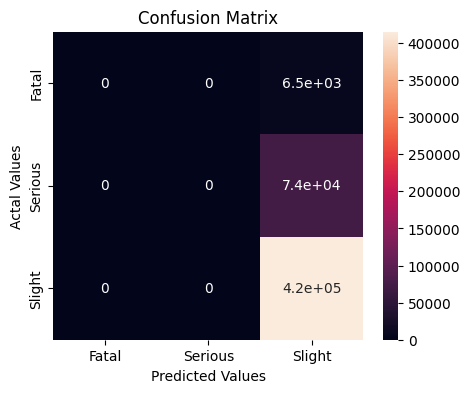

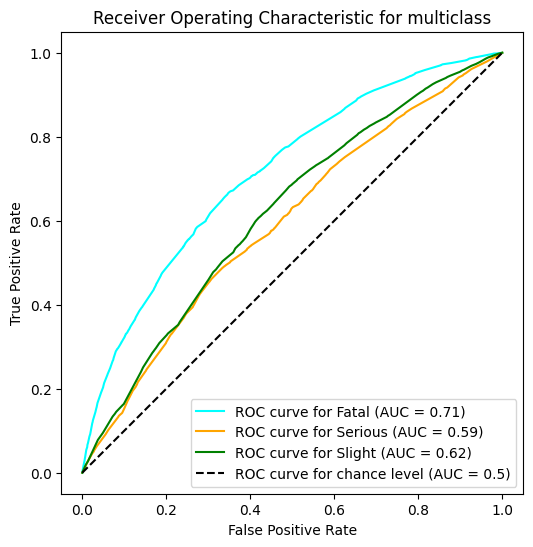

In [57]:
print("-"*20+" Adaboost Classifier "+"-"*20)
Performance_df = model_applying(clf4, X_train, y_train, X_test, y_test,target_severity,Performance_df)

In [58]:
Performance_df

,Training Acc,Test acc,Log Loss,precision,Recall,F1 Score,False Positive Rate,Error Rate
0,83.693,83.720,46.819,44.248,33.343,30.402,100.000,16.280
1,83.693,83.720,47.128,60.232,33.371,30.466,95.652,16.280
2,84.613,81.374,299.909,35.658,33.894,32.782,95.274,18.626
0,83.681,83.718,81.645,27.906,33.333,30.379,NaN,16.282


In [59]:
Performance_df.to_csv("Performance_df.csv", index= False)

## 5. Applying Bagging Classifier

In [63]:
clf5 = BaggingClassifier(max_features=X_train.shape[1], n_estimators=100, random_state=42)

In [64]:
Performance_df = pd.read_csv("Performance_df.csv")

-------------------- Bagging Classifier --------------------
Training Accuracy: 99.9842%
              precision    recall  f1-score   support

       Fatal       1.00      1.00      1.00     26043
     Serious       1.00      1.00      1.00    297696
      Slight       1.00      1.00      1.00   1660031

    accuracy                           1.00   1983770
   macro avg       1.00      1.00      1.00   1983770
weighted avg       1.00      1.00      1.00   1983770

Test Accuracy: 82.9747%
              precision    recall  f1-score   support

       Fatal       0.12      0.00      0.00      6520
     Serious       0.29      0.04      0.07     74230
      Slight       0.84      0.98      0.91    415193

    accuracy                           0.83    495943
   macro avg       0.42      0.34      0.33    495943
weighted avg       0.75      0.83      0.77    495943



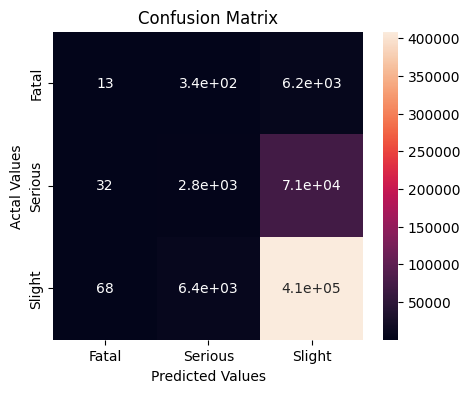

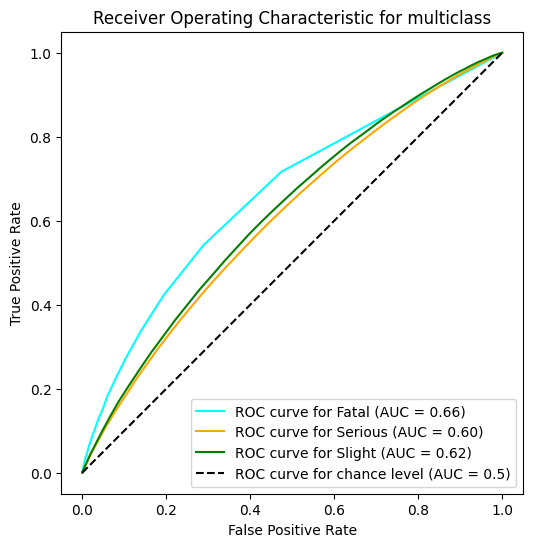

In [65]:
print("-"*20+" Bagging Classifier "+"-"*20)
Performance_df = model_applying(clf5, X_train, y_train, X_test, y_test,target_severity,Performance_df)

In [66]:
Performance_df

,Training Acc,Test acc,Log Loss,precision,Recall,F1 Score,False Positive Rate,Error Rate
0,83.693,83.720,46.819,44.248,33.343,30.402,100.000,16.280
1,83.693,83.720,47.128,60.232,33.371,30.466,95.652,16.280
2,84.613,81.374,299.909,35.658,33.894,32.782,95.274,18.626
3,83.681,83.718,81.645,27.906,33.333,30.379,NaN,16.282
0,99.984,82.975,62.579,41.603,34.136,32.584,96.328,17.025


In [67]:
Performance_df.to_csv("Performance_df.csv", index= False)

In [76]:
Performance_df

,Name of Classifier,Training Acc,Test acc,Log Loss,precision,Recall,F1 Score,False Positive Rate,Error Rate
0,Random Forest,83.693,83.720,46.819,44.248,33.343,30.402,100.000,16.280
1,XGBoost,83.693,83.720,47.128,60.232,33.371,30.466,95.652,16.280
2,KNeighborsClassifier,84.613,81.374,299.909,35.658,33.894,32.782,95.274,18.626
3,AdaBoost,83.681,83.718,81.645,27.906,33.333,30.379,NaN,16.282
0,Bagging Classifier,99.984,82.975,62.579,41.603,34.136,32.584,96.328,17.025


#### at the last result stage I reliazed i forgot most important thing , i didnt mention the names of classifier so doing this necessary arrangement now.

In [70]:
Classifiers_name = ['Random Forest', 'XGBoost',' KNeighborsClassifier','AdaBoost','Bagging Classifier']

In [71]:
Performance_df["Name of Classifier"] = Classifiers_name

In [75]:
cols = ['Name of Classifier', 'Training Acc','Test acc','Log Loss','precision','Recall','F1 Score','False Positive Rate',
        'Error Rate']
Performance_df = Performance_df[cols]